# Introduction and objectives

This lab session introduces Support Vector Machines for mining the troves of data tucked away at Twitter and classifying these tweets. 

Automatic event detection is a highly relevant research topic. In the context of sports, this often means identifying the highlights of a sports game. Twitter is a very good medium to identify the highlights of a game. During this lab, we will try to identify events that happened during a soccer game. Afterwards, we will try to adapt the algorithm for identifying highlights in a cycling race. The core of the algorithm will be a Support Vector Machine.

The goal of this lab is to:

> Recognize events during sports games using a 2-step algorithm

> Make use of a Support Vector Machine (SVM) for classification of tweets

> Understand the pitfalls of designing a generic algorithm that should be applicable to previously unseen content

To run the code, be sure that the libraries Scikit-learn and matplotlib are installed on your system. Python 2.7 is used in this exercise.

During the first 5 exercises, you will not program a lot. It is important that you try to understand the code and the design process of the algorithm because you will need to adapt it in Exercise 6.

# Exercise 1: Familiarizing with soccer data

The first task is to visualize the Twitter data on a time line. Often patterns can already be deduced this way. A file of tweets is given, containing $33565$ tweets that were sent during the game Tottenham - Manchester United with hashtag #MUFC. The game started at $17:11:43$ on television. The file is called `soccer_tweets.tsv`. Each line contains a date, user name and tweet. You can load the tweets using the function `readTsvFile(name)` which is defined below. We also define some other important classes and methods that we'll use during the exercise.

In [1]:
from datetime import datetime

class GameReader:
    # read TSV file quick and dirty
    @staticmethod
    def readTsvFile(name):
        file_to_read=open(name,'r')
        list_of_tweets=[]
        for line in file_to_read:
            split_tabs=line.split('\t')
            if len(split_tabs)>=3:
                list_of_tweets.append(Tweet(split_tabs[2],_date=split_tabs[0],_user=split_tabs[1]))
        return list_of_tweets

class AnnotationReader:
    # read TSV file quick and dirty
    @staticmethod
    def readTsvFile(name):
        file_to_read=open(name,'r')
        list_of_tweets=[]
        for line in file_to_read:
            split_tabs=line.split('\t')
            if len(split_tabs)>=2:
                list_of_tweets.append(Tweet(split_tabs[1],_label=split_tabs[0]))
        return list_of_tweets

class PlayerReader:
    # read TSV file quick and dirty
    @staticmethod
    def readTsvFile(name):
        file_to_read=open(name,'r')
        list_of_players=[]
        for line in file_to_read:
            split_tabs=line.split('\t')
            if len(split_tabs)>=4:
                
                firstnames=split_tabs[0].split(' ')
                for i in range(len(firstnames)):
                    firstnames[i]=firstnames[i].replace('#',' ').lower() 
                lastnames=split_tabs[1].split(' ')
                for i in range(len(lastnames)):
                    lastnames[i]=lastnames[i].replace('#',' ').lower() 
                list_of_players.append(Player(firstnames,lastnames,int(split_tabs[2]),split_tabs[3][:-1]))
        return list_of_players

class TeamReader:
    # read TSV file quick and dirty
    @staticmethod
    def readTsvFile(name):
        file_to_read=open(name,'r')
        list_of_teams=[]
        for line in file_to_read:
            split_tabs=line.split('\t')
            if len(split_tabs)>=3:
                list_of_teams.append(Team(int(split_tabs[0]),split_tabs[1],split_tabs[2][:-1]))
        return list_of_teams

class Tweet:
    def __init__(self, _tweet,_date="1900-01-01 00:00:00", _user="",_label=0):
        self.date=datetime.strptime(_date,"%Y-%m-%d %H:%M:%S")
        self.user=_user
        self.tweet=_tweet.rstrip('\n')
        self.label=int(_label)



class Player:
    def __init__(self,_firstnames,_lastnames,_team_nr,_position):
        self.firstnames=_firstnames #list
        self.lastnames=_lastnames #list
        self.team_nr=_team_nr
        self.position=_position

class Team:
    def __init__(self,_team_nr,_team_name,_hashtag):
        self.team_nr=_team_nr
        self.team_name=_team_name
        self.hashtag=_hashtag

Let's read the contents of the file.

In [2]:
tweetData = GameReader.readTsvFile('./soccer_tweets.tsv')

In [3]:
print(len(tweetData))
print(tweetData[0])
print(tweetData[3].tweet)

33564
<__main__.Tweet instance at 0x0000000005398C08>
RT @premierleague: Manchester United starting line-up: De Gea, Evra, Jones, Ferdinand, Evans, Carrick, Nani, Young, Scholes, Rooney, Wel ...


Now we visualize the tweets. However before that we set the starttime and end time of the game which will be treated as "constants" for the rest of the exercise.

In [4]:
# enter start date of game
START_TIME = datetime.strptime("2012-03-04 17:11:43","%Y-%m-%d %H:%M:%S")
# we set the duration of the game to 2 hours
END_TIME = datetime.strptime("2012-03-04 19:11:43","%Y-%m-%d %H:%M:%S")

For visualizations, we'll be using matplotlib library. We are going to plot the tweet volume as a of time. The plot shows the number of tweets per minute. 

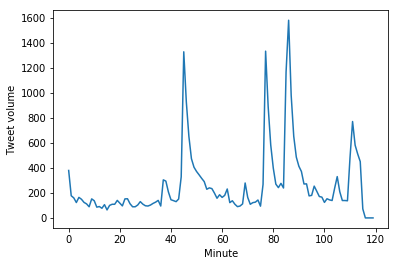

In [6]:
import matplotlib.pyplot as plt

#initialize list of minutes
N_points_min = (END_TIME - START_TIME).seconds / 60
points_of_graph_min = [0]*int(N_points_min)

for tweet in tweetData:
    if tweet.date < START_TIME or tweet.date >= END_TIME:
        continue 
    # compute difference of dates, in seconds
    time_delta = tweet.date - START_TIME
    # calculate minute sent during the game
    minute = time_delta.seconds / 60
    
    # increase per minute count
    points_of_graph_min[int(minute)] += 1

plt.plot(range(int(N_points_min)), points_of_graph_min)
plt.ylabel('Tweet volume')
plt.xlabel('Minute')
plt.show()

###### Describe the shape of the graph and try to explain in detail the reason why the graph looks like this?

Confirm your hypotheses from the data that you just used. 

> When something happens, more tweets are sent.

# Exercise 2: Determining events during a soccer game in Twitter

We'll use the peculiar shape of the previous graph to detect events during the game. That is, we can make use of the sudden rise in the tweet volume to detect events during a soccer game. The idea is that if the tweet volume rises with factor x in a short time span, an event has happened. We can define this time span as a search window and compare the tweet volume in the first half of the search window with the tweet volume in the second half of the search window. Stated more formally, an event is detected when:

$$\frac{\text{number of tweets} \in \text{second half search window}}{\text{number of tweets} \in \text{first half search window}} > \delta_1$$

The most optimal threshold $\delta_1$ and search window size $\Delta T$ should be determined via experiment. The value of $\delta_1$ determines how steep the increase of the tweet volume should be to detect an event. The value of $\Delta T$ is determined by a number of criteria such as the general tweet volume of the game, being sensitive to bursts and being able to detect an event.


The purpose of this and the next exercises is to detect soccer goals. The following goal events were reported in the Twitter data starting around a certain point of time:

> $17:56:20$ Wayne Rooney scores for Manchester United $(0-1)$

> $18:28:30$ Ashley Young scores for Manchester United $(0-2)$

> $18:36:55$ Ashley Young scores for Manchester United $(0-3)$

> $18:55:55$ Jermain Defoe scores for Tottenham $(1-3)$

Try to tweak the values of $\delta_1$ and $\Delta T$ such that at least all three goals of Manchester United could be detected using the search window. This means that at least one increase in tweet volume is detected around the time each goal was scored, containing some tweets that report a goal was scored.

Below we define some helper functions.

In [6]:
from __future__ import division
import re

class CustomFeatureExtractor:
    
    def countExclamationMarks(self,text):
        return text.count('!')

    def countWordsInCapitalLetters(self,text):
        words=text.split(" ")
        number=0
        for word in words:
            if word.upper()==word:
                number+=1
        return number

    def Ex4CustomFeature(self,text):
        total = 0
        start = 0
        there = re.compile('\d-\d')
        while True:
            mo = there.search(text, start)
            if mo is None: return total
            total += 1
            start = 1 + mo.start()

In [7]:
def sum_window(array, begin_index, end_index):
    sum=0
    for i in range(begin_index,end_index):
        sum+=array[i]
    return sum

Below we define some pre-processor functions. You might have to update the location of `players.tsv` and `teams.tsv` files in the `__init__()`.

In [8]:
import re

class PreProcessor:

    def __init__(self):
        self.list_of_players=PlayerReader.readTsvFile("./players.tsv")
        self.preProcessPlayers()
        self.list_of_teams=TeamReader.readTsvFile("./teams.tsv")
        self.preProcessHashtags()

    def preProcess(self,text):
        #text = self.removeRepetition(text)
        #text = self.replacePlayers(text)
        text = self.replaceHashtags(text)
        return text

    def removeRepetition(self,text):
        return re.sub(r'([a-zA-Z])\1+', r'\1', text)
    
    def replacePlayers(self,text):
        words=text.split(' ')
        return_text=""
        for word in words:
            if self.isFirstName(word):
                return_text+="_F_PLAYERNAME_"+" "
            elif self.isLastName(word):
                return_text+="_L_PLAYERNAME_"+" "
            else:
                return_text+=word+" "
        return return_text

    def replaceHashtags(self,text):
        words=text.split(' ')
        return_text=""
        for word in words:
            if self.isHashtag(word):
                return_text+="_TEAM_HASHTAG_"+" "
            else:
                return_text+=word+" "
        return return_text

    def isFirstName(self,word):
        for player in self.list_of_players:
            if word.lower() in player.firstnames:
                return 1
        return 0

    def isLastName(self,word):
        for player in self.list_of_players:
            if word.lower() in player.lastnames:
                return 1
        return 0

    def isHashtag(self,word):
        for team in self.list_of_teams:
            if word.lower() in team.hashtag:
                return 1
        return 0

    def preProcessPlayers(self):
        for player_it in range(len(self.list_of_players)):
            for i in range(len(self.list_of_players[player_it].firstnames)):
                self.list_of_players[player_it].firstnames[i]=self.removeRepetition(self.list_of_players[player_it].firstnames[i]).lower()
            for i in range(len(self.list_of_players[player_it].lastnames)):
                self.list_of_players[player_it].lastnames[i]=self.removeRepetition(self.list_of_players[player_it].lastnames[i]).lower()

    def preProcessHashtags(self):
        for team_it in range(len(self.list_of_teams)):
            self.list_of_teams[team_it].hashtag=self.list_of_teams[team_it].hashtag.lower()

The code below does the requisite. For referencing purposes, we'll refer to this code as detect_events.

In [9]:
# from __future__ import division
from datetime import timedelta
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn import preprocessing
import pickle
import numpy as np
from scipy.sparse import csr_matrix,hstack
from scipy import sparse


##############
# Parameters #
##############
# Use these parameters for controlling the algorithm. No other modifications are necessary for the lab.

# Parameters exercise 2
ex2_active = 1
delta1_threshold = 2.5
search_window = 30  # seconds

# Parameters exercise 5
ex5_active = 1
pickle_model="goal_model.p"
pickle_count="vectorizerCount.p"
pickle_tfidf="vectorizerTFIDF.p"
pickle_scaler="scaler.p"
delta2_threshold=0.3


####################
# Helper functions #
####################
############################################
# Make per second list of the tweet volume #
############################################

#initialize list of seconds
N_points = (END_TIME - START_TIME).seconds 
points_of_graph=[0]*N_points

#overview of tweets per second
tweet_dictionary={}

for tweet in tweetData:
    if tweet.date < START_TIME or tweet.date >= END_TIME:
        continue 
    # compute difference of dates, in seconds
    time_delta = tweet.date - START_TIME
    # calculate second sent during the game
    second = time_delta.seconds 
    # store all tweets in per second dictionary
    if not second in tweet_dictionary:
        tweet_dictionary[second]=[]
    tweet_dictionary[second].append(tweet)

    # increase per minute count
    points_of_graph[second]+=1

    
#################
# Detect events #
#################

index = search_window

if ex5_active:
    model=pickle.load(open(pickle_model,"rb"))
    vect=pickle.load(open(pickle_count,"rb"))
    tf_transformer=pickle.load(open(pickle_tfidf,"rb"))
    min_max_scaler = pickle.load(open(pickle_scaler,"rb"))
    goal_seconds=[-100]
    preprocessor=PreProcessor()

while index < N_points - search_window:
    window_first_half = sum_window(points_of_graph, index-search_window//2, index)
    window_2nd_half = sum_window(points_of_graph, index, index+search_window//2)
    delta_1 = window_2nd_half/(window_first_half if window_first_half!=0 else 1)

    #######################################################
    # Step 1                                              #
    #######################################################
    if delta_1 > delta1_threshold:
        if ex2_active:
            print("Highlight found between " + (START_TIME + timedelta(seconds=(index-search_window//2))).strftime("%H:%M:%S")+" - " + 
                  (START_TIME+timedelta(seconds=(index+search_window//2))).strftime("%H:%M:%S"))

        #######################################################
        # Step 2                                              #
        #######################################################
        if ex5_active:
            search_index=index
            total_tweets=0
            goal_tweets=0

            while search_index < index+search_window//2:
                if search_index in tweet_dictionary:
                    for tweet in tweet_dictionary[search_index]:
                        # Vectorize to word features
                        tweet_list=[preprocessor.preProcess(tweet.tweet)]
                        tweets_vector = vect.transform(tweet_list)
                        tweets_vector_tf = tf_transformer.transform(tweets_vector)

                        # Add custom features
                        tweets_matrix=tweets_vector_tf
                        # define new matrix with size (nr_of_tweets,nr_of_features)
                        custom_features=np.zeros((1,3))
                        cfe = CustomFeatureExtractor()
                        custom_features[0,0]=cfe.countExclamationMarks((tweet.tweet))
                        custom_features[0,1]=cfe.countWordsInCapitalLetters((tweet.tweet))
                        custom_features[0,2]=cfe.Ex4CustomFeature((tweet.tweet))

                        # merge word features and custom features
                        tweets_matrix=hstack([tweets_vector_tf,custom_features])

                        #scale
                        tweets_matrix = min_max_scaler.transform(tweets_matrix.toarray())

                        #predict
                        prediction = model.predict(tweets_matrix)

                        # check if goal tweet
                        if prediction[0]==1:
                            goal_tweets+=1
                        total_tweets+=1

                search_index+=1

            if goal_tweets / total_tweets > delta2_threshold:
                goal_seconds.append(index)
                print("goal detected")

    index+=1

#print summary
if ex5_active:
    print("\nSummary:")
    for i in range(len(goal_seconds)-1):
        # if difference between 2 different event moments is bigger than 30 seconds, assume new event
        if goal_seconds[i+1]-goal_seconds[i]>30:
            print("Goal detected around "+(START_TIME+timedelta(seconds=(goal_seconds[i+1]))).strftime("%H:%M:%S"))

Highlight found between 17:33:50 - 17:34:20
Highlight found between 17:33:51 - 17:34:21
Highlight found between 17:33:52 - 17:34:22
Highlight found between 17:33:53 - 17:34:23
Highlight found between 17:33:55 - 17:34:25
Highlight found between 17:33:56 - 17:34:26
Highlight found between 17:33:57 - 17:34:27
Highlight found between 17:56:01 - 17:56:31
goal detected
Highlight found between 17:56:02 - 17:56:32
goal detected
Highlight found between 17:56:03 - 17:56:33
goal detected
Highlight found between 17:56:04 - 17:56:34
goal detected
Highlight found between 17:56:05 - 17:56:35
goal detected
Highlight found between 17:56:06 - 17:56:36
goal detected
Highlight found between 17:56:07 - 17:56:37
goal detected
Highlight found between 17:56:08 - 17:56:38
goal detected
Highlight found between 17:56:09 - 17:56:39
goal detected
Highlight found between 17:56:10 - 17:56:40
goal detected
Highlight found between 17:56:11 - 17:56:41
goal detected
Highlight found between 17:56:12 - 17:56:42
goal detec

###### Write down which values were the most optimal. Were you able to detect soccer goals only or were other events detected too?

(delta1_threshold = 1) and (search_window = 30) -> not effective

(delta1_threshold = 2.5) and (search_window = 30) -> effective, but not optimized (found all 4, but a lot of noise included)

(delta1_threshold = 5.4) and (search_window = 33) ->  rather effective, optimized (found 3, but not a lot of noise included)

Other events (noise) are detected too, this is because goals are not the only thing that people tweet about.

# Exercise 3: Identifying soccer events using word features

In the previous exercise, we designed and tweaked an algorithm for detecting events in Twitter data. This is different from identifying events. The only thing the algorithm can tell us, in a general case, is that an event has happened, not which event has happened.

To identify which event has happened, we will classify tweets in different classes. For the sake of simplicity, we limit ourselves in this exercise to two different classes: goals and other/no events. Because training and testing on one game will limit the generalizability of our classification model, an independent training set is given, consisting of 600 randomly selected tweets from five soccer games. The training set is equally separated in goal tweets (label=1) and no-goal tweets (label=0). 

The tweets were annotated following the following rule: a tweet will get label "1" when the content clearly indicates that a goal was just scored, taking into account the time the tweet was sent. Annotating these tweets is therefore a subjective task. Normally, multiple annotators should annotate the tweets with labels individually. The tweets can be found in twitter_annotated_trainingset_soccer.tsv.

For the classification we will make use of a Support Vector Machine with a RBF kernel and word [n-grams](https://en.wikipedia.org/wiki/N-gram). Support Vector Machines (SVMs) are state-of-the-art when it comes to text classification and yield outstanding results in most cases. We will make use again of Scikit-learn for Python. 

By default the implementation of the SVM makes use of a RBF kernel. Run the implementation provided below for training and evaluating a Support Vector Machine on the training set, making use of [5-fold cross validation](http://statweb.stanford.edu/~tibs/sta306bfiles/cvwrong.pdf). Next, switch the value of 'ex3_active_guassian' to one to train and evaluate a Naive Bayes classifier on the same set using 5-fold cross validation. 

In [10]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import cross_validation
from sklearn import preprocessing
import numpy as np
from scipy.sparse import coo_matrix,hstack
import pickle

##############
# Parameters #
##############

# use Guassian Naive Bayes Classifier
ex3_active_guassian=0
# use custom features
ex4_active=1

##############
##############


annotated_tweets = AnnotationReader.readTsvFile("./twitter_annotated_trainingset_soccer.tsv")

corpus=[]
labels=np.zeros(len(annotated_tweets))
preprocessor=PreProcessor()


#######################################################
# Preprocess corpus                                   #
#######################################################
index=0
for index in range(len(annotated_tweets)):
    corpus.append(preprocessor.preProcess(annotated_tweets[index].tweet))
    labels[index]=annotated_tweets[index].label
    index+=1

    
#######################################################
# Vectorize to word features                          #
#######################################################
vect = CountVectorizer(min_df=1)
tweets_vector = vect.fit_transform(corpus)
tf_transformer = TfidfTransformer(use_idf=False).fit(tweets_vector)
tweets_vector_tf = tf_transformer.transform(tweets_vector)


########################################################
# Add custom features                                  #
########################################################
if ex4_active:
    # define new matrix with size (nr_of_tweets,nr_of_features)
    custom_features=np.zeros((tweets_vector_tf.shape[0],3))
    cfe = CustomFeatureExtractor()
    index=0
    for index in range(len(annotated_tweets)):
        custom_features[index,0]=cfe.countExclamationMarks((annotated_tweets[index].tweet))
        custom_features[index,1]=cfe.countWordsInCapitalLetters((annotated_tweets[index].tweet))
        custom_features[index,2]=cfe.Ex4CustomFeature((annotated_tweets[index].tweet))
        index+=1

    # merge word features and custom features
    tweets_matrix=hstack([tweets_vector_tf,custom_features])
else:
    tweets_matrix=tweets_vector_tf


###############################################################
## train a model on the corpus using 5-fold cross validation ##
###############################################################
#######################################################
# Change kernel and kernel parameters of the SVM here #
#######################################################
min_max_scaler = preprocessing.MinMaxScaler()
tweets_matrix = min_max_scaler.fit_transform(tweets_matrix.toarray())
#clf = svm.SVC()
clf = svm.SVC(C = 30, gamma = 0.1)
clf.fit(tweets_matrix,labels)

#######################################################
# Uncomment this to use a Gaussian Kernel             #
#######################################################
if ex3_active_guassian:
    clf = GaussianNB()
    tweets_matrix=tweets_vector_tf.toarray()
#######################################################

# actually, here we refit the model but we want to evaluate the best parameters using cross validation
scores = cross_validation.cross_val_score(clf, tweets_matrix,labels, cv=5)

# print average accuray of 5 folds
print(np.mean(scores))
pickle.dump(clf,open("goal_model.p","wb"))
pickle.dump(tf_transformer,open("vectorizerTFIDF.p","wb"))
pickle.dump(vect,open("vectorizerCount.p","wb"))
pickle.dump(min_max_scaler,open("scaler.p","wb"))
#print(vect.get_feature_names())

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


0.835


###### Write down the results of both evaluations. What do you conclude?

default = 0.7016666666666667

ex3_active_guassian=1 = 0.6849999999999999

Guassian Naive Bayes Classifier is not the best classifier out there.

As seen during the theory, a limited number of parameters can be tweaked to get a higher accuracy. By default, the parameters of the SVM with a RBF kernel are:

* $C = 1$ (Cost)
* $ \gamma = \frac{1}{\text{number of features}}$

Add those parameters to the constructor of svm.SVC and retrain the model. You may refer to the documentation of scikit-learn for more information on `svm.SVC()` function.

###### Write down the maximum accuracy you obtained while tweaking the values of $C$ and $\gamma$. What is the meaning of those two parameters? Is it advantageous to have high values for $C$ and $\gamma$ ?

ex3_active_guassian=0:

    clf = svm.SVC(C = 1, gamma = "auto") -> 0.7016666666666667

    clf = svm.SVC(C = 5800, gamma = 0.1) -> 0.7849999999999999
    
    clf = svm.SVC(C = 5500, gamma = 0.001) -> 0.76
    
    clf = svm.SVC(C = 30, gamma = 0.001) -> 0.7216666666666667
    
    clf = svm.SVC(C = 30, gamma = 0.1) -> 0.7849999999999999 -> best
    
C is how much we penalize the SVM for data points within the margin (where "within" can also mean on the wrong side of the dividing hyperplane). Large C means penalize a lot. If your C is large, the SVM will try to find a hyperplane and margin so that there are few very points within the margin, which could mean an overly complex model with a small margin if the points aren't easily separable. A lower C gives higher error on the training set, but finds a larger margin that might be more robust.

Gamma defines how far the influence of single training example reaches. In the RBF kernel, it adjusts how similar two points must be to be considered "similar". 

If the value of Gamma is high, then our decision boundary will depend on points close to the decision boundary and nearer points carry more weights than far away points due to which our decision boundary becomes more wiggly.

If the value of Gamma is low, then far away points carry more weights than nearer points and thus our decision boundary becomes more like a straight line.

The value of gamma and C should not be very high because it leads to the overfitting or it shouldn’t be very small (underfitting). Thus we need to choose the optimal value of C and Gamma in order to get a good fit.

(Source: https://www.quora.com/What-is-the-intuition-behind-the-Cost-and-Gamma-parameters-in-SVM)

Vectorizing documents without pre-processing them often yields to sparse, unwanted and not generalizable results. You can print the vocabulary of the Vectorizer making use of the function get_feature_names(). If you move towards words starting with the character 'g', a lot variants on the word 'goal' are included. Using those variants yields suboptimal results because the chance of finding the same word again in another tweet is small. One can imagine that the word 'goaaaaaaaaaaaaaaaaaaaaaal' with 22 occurrences of 'a' is rare. 

One solution would be to reduce all those variants to one root, namely 'goal', i.e. the so called stemming. To apply this type of stemming, activate the `removeRepetition` function in the `preProcess` function of `PreProcessor` class. Run the algorithm again for training with the most optimal values for $C$ and $\gamma$ you found earlier. 

###### What is the accuracy you obtained?

Uncommented: text = self.removeRepetition(text)

Params: 

    ex3_active_guassian=0
    
    clf = svm.SVC(C = 30, gamma = 0.1)

Result: 0.8066666666666666

Similarly, a lot of tweets contain player mentions and hashtags. Because the model of the SVM is trained on a selection of games and teams, it will not generalize well to other games with teams that were not represented in the training set. Therefore, we will replace player names with a general token based on a list of players of the English Premier League, extracted from Soccerway (http://soccerway.com). The list is provided as players.tsv. The columns represent respectively the first name(s) of the player, the last name(s) of the player, the team number of the player and his position on the field. We will replace the first names with the token `'_F_PLAYERNAME_'` and the last names with the token `'_L_PLAYERNAME_'`. To apply this preprocessing step, activate the function `replacePlayers` in the `preProcess` function of the `PreProcess` class. 

Run the training algorithm again. 

###### Which accuracy did you obtain? Did the accuracy improve? Explain why?

Uncommented: 

    text = self.removeRepetition(text)
    
    text = self.replacePlayers(text)
    
Params: 

    ex3_active_guassian=0
    
    clf = svm.SVC(C = 30, gamma = 0.1)

Result: 0.8033333333333333

It got worse, probably people not using the correct names or adding [´ ` . , etc] to the name, those are not filtered out. This filter is thus not the most effective.

###### Can you further improve this accuracy by tweaking the values of $C$ and $\gamma$?

clf = svm.SVC(C = 5500, gamma = 0.1) -> 0.7916666666666666

clf = svm.SVC(C = 5500, gamma = 0.001) -> 0.76

clf = svm.SVC(C = 10, gamma = 0.001) -> 0.7233333333333334

clf = svm.SVC(C = 10, gamma = 0.1) -> 0.7916666666666666

-> not improving

We can do the same for the hashtags used. Activate the function `replaceHashtags` in the `preProcess` function in the `PreProcess` class to replace the team hashtags with the token `'_TEAM_HASHTAG_'`.

###### Did the accuracy improve? Explain why?

Uncommented: 

    text = self.removeRepetition(text)
    
    text = self.replacePlayers(text)
    
    text = self.replaceHashtags(text)
    
Params: 

    ex3_active_guassian=0
    
    clf = svm.SVC(C = 30, gamma = 0.1)

Result: 0.7833333333333333 -> it got worse

Reason: football consists of 2 teams, this means theres not a lot of words to reduce.

# Exercise 4: Identifying soccer events using custom features

A consequence of reducing all words to a common root, is that discriminative information is removed too. Repetition and capitalization of characters are mark-up tools used by users to express joy or anger. Those feelings are often related to events we want to detect. By removing them, we remove a part of the important information too. Note that when you apply the TF-IDF transformer of `scikit-learn`, capitalization is automatically removed. Therefore, it can be useful to define some custom features to capture these characteristics instead of using standard word features. This is called feature engineering, namely, selecting features that will improve the classification result, based on the context at hand.

###### Change the value of ex4_active to one in the code block for exercise 3 to use some custom features.

done: ex4_active=1

###### Two features are already implemented. Run the algorithm and write down the best accuracy that you obtained while tweaking $C$ and $\gamma$.

Preprocessor: all 3 filters on

    clf = svm.SVC(C = 30, gamma = 0.1) -> 0.7866666666666666

    clf = svm.SVC(C = 30, gamma = 0.001) -> 0.7633333333333333

    clf = svm.SVC(C = 5500, gamma = 0.001) -> 0.7683333333333333

    clf = svm.SVC(C = 5500, gamma = 0.1) -> 0.7633333333333334

    clf = svm.SVC(C = 5, gamma = 0.15) -> 0.8033333333333333

Preprocessor: only removerepitition on

    clf = svm.SVC(C = 30, gamma = 0.1) -> 0.8066666666666666 -> best
    
    clf = svm.SVC(C = 5, gamma = 0.15) -> 0.8033333333333333


Some other custom features can be defined. Try to invent one yourself that improves the accuracy on the training set. This can be a combination of multiple features. You can make use of all other given functions and files. 

###### Add it to the CustomFeatureExtractor class and call it Ex4CustomFeature. Do not forget to adapt the file the code block in Exercise 3 too. Write down the accuracy you obtained, which features you used and which parameters ($C$ and $\gamma$) that were used for evaluation.

Preprocessor all 3 filters on + all features on:

    clf = svm.SVC(C = 30, gamma = 0.1) -> 0.8183333333333334

Preprocessor only removerepitition on + all features on:

    clf = svm.SVC(C = 5, gamma = 0.15) -> 0.8216666666666667
    
    clf = svm.SVC(C = 30, gamma = 0.1) -> 0.8399999999999999 -> best

# Exercise 5: Testing the algorithm

The final algorithm for testing events is a 2-step algorithm. Because we know that events give rise to high peaks in the Twitter volume, we will first apply the peak detection algorithm of Exercise 2. When a peak is detected, we move on to step 2 where we classify all tweets within the search window in 2 classes, goal tweets and no-goal tweets. When the number of goal tweets exceeds a threshold $\gamma_2$, a goal event is detected:

$$\frac{\text{number of goal tweets}}{\text{total number of tweets}} > \delta_2$$

Activate the second step in detect_events by changing the value of `ex5_active` to one. Modify the value of $\delta_2$ until you get a good result. Note that you can estimate a good threshold value by printing out all thresholds that were calculated. Try to detect as much goals as possible while suppressing events that gave a peak in step one but are not goal events. 

###### Did you succeed? Write down the summary you got and explain the result.

Uncommented:
    
    text = self.removeRepetition(text)
    
    text = self.replacePlayers(text)
    
    text = self.replaceHashtags(text)

Params:

    delta1_threshold = 5.4 and search_window = 33:
    
        delta2_threshold=1 -> No goals detected
    
        delta2_threshold=0.3 -> Goal detected around 17:56:22, 18:28:29, 18:36:58
        
    delta1_threshold = 2.5 and search_window = 30:
    
        delta2_threshold=0.3 -> Goal detected around 17:56:16, 18:28:22, 18:36:52, 18:55:53
        
All goals have been found!

To prove that replacing player names and hashtags really yields a generalizable goal event detection system, retrain the SVM model without the preprocessing steps `replacePlayers` and `replaceRepetition`. Run the detect_events algorithm again. 

###### Which goals can be detected? Why? 

Uncommented:
    
    text = self.replaceHashtags(text)

Params:
        
    delta1_threshold = 2.5 and search_window = 30:
    
        delta2_threshold=0.3 -> Goal detected around 17:56:16, 18:28:22, 18:36:52, 18:55:53
 
All goals have been found, just as before.

It can be useful to print the values of $\frac{\text{number of goal tweets}}{\text{total number of tweets}}$. You will probably need to change the value of $\delta_2$ too to detect some soccer goals.

# Exercise 6: Event detection and identification in cycling races

In this exercise, we will try to modify the algorithm we have developed in the previous lab session to detect events during cycling races. Six different races are given: Milaan-San Remo (#msr), Gent-Wevelgem (#gw), Ronde van Vlaanderen (#rvv), Parijs-Roubaix (#roubaix), Amstel Gold Race (#agr) en Luik-Bastenaken-Luik (#lbl). The goal is to identify a cycling race event. Which one is up to you. Analyze the given races carefully to select an interesting event.

You can use and modify the code of the previous lab as much as you want. You can use external sources of code or information too. 

As a help, you can take the following path:

* Divide the given cycling races in a test and training set

* Analyze the training set and try to identify interesting event types

* Select an event type, select some representative tweets for that event type and label them (select for both classes the same amount of tweets)

* For that event type, identify the most promising features to identify such an event (n-grams, selection of keywords, custom features)

* Adapt the given code to use those features and train the algorithm to identify that type of event on the training set

* Evaluate your algorithm on the test set


New files:

    players_cyclers.tsv: similar to players.tsv

    teams_cycling.tsv: similar to teams.tsv
    
    cycling_annotated.tsv: similar to twitter_annotated_trainingset_soccer.tsv

In [7]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import cross_validation
from sklearn import preprocessing
import numpy as np
from scipy import sparse
from scipy.sparse import coo_matrix,hstack,csr_matrix
import pickle
from datetime import timedelta,datetime
import matplotlib.pyplot as plt
from __future__ import division
import re

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [38]:
class GameReader:
    # read TSV file quick and dirty
    @staticmethod
    def readTsvFile(name):
        file_to_read=open(name,'r')
        list_of_tweets=[]
        for line in file_to_read:
            split_tabs=line.split('\t')
            if len(split_tabs)>=3:
                list_of_tweets.append(Tweet(split_tabs[2],_date=split_tabs[0],_user=split_tabs[1]))
        return list_of_tweets

class AnnotationReader:
    # read TSV file quick and dirty
    @staticmethod
    def readTsvFile(name):
        file_to_read=open(name,'r')
        list_of_tweets=[]
        for line in file_to_read:
            split_tabs=line.split('\t')
            if len(split_tabs)>=2:
                list_of_tweets.append(Tweet(split_tabs[1],_label=split_tabs[0]))
        return list_of_tweets

class PlayerReader:
    # read TSV file quick and dirty
    @staticmethod
    def readTsvFile(name):
        file_to_read=open(name,'r')
        list_of_players=[]
        for line in file_to_read:
            split_tabs=line.split('\t')
            if len(split_tabs)>=4:
                firstnames=split_tabs[0].split(' ')
                for i in range(len(firstnames)):
                    firstnames[i]=firstnames[i].replace('#',' ').lower() 
                lastnames=split_tabs[1].split(' ')
                for i in range(len(lastnames)):
                    lastnames[i]=lastnames[i].replace('#',' ').lower() 
                list_of_players.append(Player(firstnames,lastnames,int(split_tabs[2]),split_tabs[3][:-1]))
        return list_of_players

class TeamReader:
    # read TSV file quick and dirty
    @staticmethod
    def readTsvFile(name):
        file_to_read=open(name,'r')
        list_of_teams=[]
        for line in file_to_read:
            split_tabs=line.split('\t')
            if len(split_tabs)>=3:
                list_of_teams.append(Team(int(split_tabs[0]),split_tabs[1],split_tabs[2][:-1]))
        return list_of_teams

class Tweet:
    def __init__(self, _tweet,_date="1900-01-01 00:00:00", _user="",_label=0):
        self.date=datetime.strptime(_date,"%Y-%m-%d %H:%M:%S")
        self.user=_user
        self.tweet=_tweet.rstrip('\n')
        self.label=int(_label)

class Player:
    def __init__(self,_firstnames,_lastnames,_team_nr,_position):
        self.firstnames=_firstnames #list
        self.lastnames=_lastnames #list
        self.team_nr=_team_nr
        self.position=_position

class Team:
    def __init__(self,_team_nr,_team_name,_hashtag):
        self.team_nr=_team_nr
        self.team_name=_team_name
        self.hashtag=_hashtag

class CustomFeatureExtractor:
    def countExclamationMarks(self,text):
        return text.count('!')

    def countWordsInCapitalLetters(self,text):
        words=text.split(" ")
        number=0
        for word in words:
            if word.upper()==word:
                number+=1
        return number
    
def sum_window(array, begin_index, end_index):
    sum=0
    for i in range(begin_index,end_index):
        sum+=array[i]
    return sum

class PreProcessor:
    def __init__(self):
        self.list_of_players=PlayerReader.readTsvFile("./players_cyclers.tsv")
        self.preProcessPlayers()
        self.list_of_teams=TeamReader.readTsvFile("./teams_cycling.tsv")
        self.preProcessHashtags()

    def preProcess(self,text):
        text = self.removeRepetition(text)
        text = self.replacePlayers(text)
        text = self.replaceHashtags(text)
        return text

    def removeRepetition(self,text):
        return re.sub(r'([a-zA-Z])\1+', r'\1', text)
    
    def replacePlayers(self,text):
        words=text.split(' ')
        return_text=""
        for word in words:
            if self.isFirstName(word):
                return_text+="_F_PLAYERNAME_"+" "
            elif self.isLastName(word):
                return_text+="_L_PLAYERNAME_"+" "
            else:
                return_text+=word+" "
        return return_text

    def replaceHashtags(self,text):
        words=text.split(' ')
        return_text=""
        for word in words:
            if self.isHashtag(word):
                return_text+="_TEAM_HASHTAG_"+" "
            else:
                return_text+=word+" "
        return return_text

    def isFirstName(self,word):
        for player in self.list_of_players:
            if word.lower() in player.firstnames:
                return 1
        return 0

    def isLastName(self,word):
        for player in self.list_of_players:
            if word.lower() in player.lastnames:
                return 1
        return 0

    def isHashtag(self,word):
        for team in self.list_of_teams:
            if word.lower() in team.hashtag:
                return 1
        return 0

    def preProcessPlayers(self):
        for player_it in range(len(self.list_of_players)):
            for i in range(len(self.list_of_players[player_it].firstnames)):
                self.list_of_players[player_it].firstnames[i]=self.removeRepetition(self.list_of_players[player_it].firstnames[i]).lower()
            for i in range(len(self.list_of_players[player_it].lastnames)):
                self.list_of_players[player_it].lastnames[i]=self.removeRepetition(self.list_of_players[player_it].lastnames[i]).lower()

    def preProcessHashtags(self):
        for team_it in range(len(self.list_of_teams)):
            self.list_of_teams[team_it].hashtag=self.list_of_teams[team_it].hashtag.lower()

In [39]:
tweetData = GameReader.readTsvFile('./gw.tsv')
#tweetData = GameReader.readTsvFile('./roubaix.tsv')
#tweetData = GameReader.readTsvFile('./msr.tsv') # not working
# tweetData = GameReader.readTsvFile('./lbl.tsv')

Analyze the set and try to identify events:

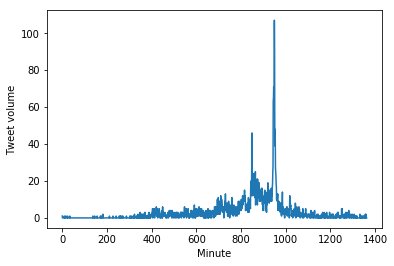

In [40]:
# GW:
START_TIME = datetime.strptime("2013-03-24 00:20:42","%Y-%m-%d %H:%M:%S")
END_TIME = datetime.strptime("2013-03-24 23:04:36","%Y-%m-%d %H:%M:%S")
# # roubaix
# START_TIME = datetime.strptime("2013-04-07 00:06:36","%Y-%m-%d %H:%M:%S")
# END_TIME = datetime.strptime("2013-04-07 22:01:27","%Y-%m-%d %H:%M:%S")
# # MSR:
# START_TIME = datetime.strptime("2013-03-17 00:05:23","%Y-%m-%d %H:%M:%S")
# END_TIME = datetime.strptime("2013-03-17 23:11:13","%Y-%m-%d %H:%M:%S")
# # LBL:
# START_TIME = datetime.strptime("2013-04-21 00:11:46","%Y-%m-%d %H:%M:%S")
# END_TIME = datetime.strptime("2013-04-21 22:00:50","%Y-%m-%d %H:%M:%S")
#initialize list of minutes
N_points_min = (END_TIME - START_TIME).seconds / 60
points_of_graph_min = [0]*int(N_points_min)
for tweet in tweetData:
    if tweet.date < START_TIME or tweet.date >= END_TIME:
        continue 
    # compute difference of dates, in seconds
    time_delta = tweet.date - START_TIME
    # calculate minute sent during the game
    minute = time_delta.seconds / 60
    # increase per minute count
    points_of_graph_min[int(minute)] += 1

plt.plot(range(int(N_points_min)), points_of_graph_min) 
plt.ylabel('Tweet volume')
plt.xlabel('Minute')
plt.show()

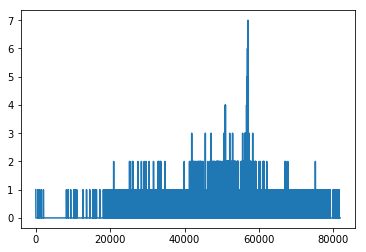

In [41]:
# Make per second list of the tweet volume #
#initialize list of seconds
N_points = (END_TIME - START_TIME).seconds 
points_of_graph=[0]*N_points
#overview of tweets per second
tweet_dictionary={}
for tweet in tweetData:
    if tweet.date < START_TIME or tweet.date >= END_TIME:
        continue 
    # compute difference of dates, in seconds
    time_delta = tweet.date - START_TIME
    # calculate second sent during the game
    second = time_delta.seconds 
    # store all tweets in per second dictionary
    if not second in tweet_dictionary:
        tweet_dictionary[second]=[]
    tweet_dictionary[second].append(tweet)
    points_of_graph[second]+=1
    
plt.plot(range(int(N_points)), points_of_graph) 
plt.show()

In [42]:
delta1_threshold = 7.5
search_window = 50

# #GW
# delta1_threshold = 7.5
# search_window = 50

# #roubaix
# delta1_threshold = 6
# search_window = 33

# #LBL
# delta1_threshold = 6.6
# search_window = 30

index = search_window

pickle_model="goal_model.p"
pickle_count="vectorizerCount.p"
pickle_tfidf="vectorizerTFIDF.p"
pickle_scaler="scaler.p"

delta2_threshold=0.25
# #GW
# delta2_threshold=0.25

# #roubaix
# delta2_threshold=0.30

# #LBL
# delta2_threshold=0.25

model=pickle.load(open(pickle_model,"rb"))
vect=pickle.load(open(pickle_count,"rb"))
tf_transformer=pickle.load(open(pickle_tfidf,"rb"))
min_max_scaler = pickle.load(open(pickle_scaler,"rb"))
goal_seconds=[-100]
preprocessor=PreProcessor()

while index < N_points - search_window:
    window_first_half = sum_window(points_of_graph, index-search_window//2, index)
    window_2nd_half = sum_window(points_of_graph, index, index+search_window//2)
    delta_1 = window_2nd_half/(window_first_half if window_first_half!=0 else 1)
    if delta_1 > delta1_threshold:
        print("Highlight found between " + (START_TIME + timedelta(seconds=(index-search_window//2))).strftime("%H:%M:%S")+" - " +(START_TIME+timedelta(seconds=(index+search_window//2))).strftime("%H:%M:%S"))
    
        search_index=index
        total_tweets=0
        goal_tweets=0

        while search_index < index+search_window//2:
            if search_index in tweet_dictionary:
                for tweet in tweet_dictionary[search_index]:
                    # Vectorize to word features
                    tweet_list=[preprocessor.preProcess(tweet.tweet)]
                    tweets_vector = vect.transform(tweet_list)
                    tweets_vector_tf = tf_transformer.transform(tweets_vector)

                    # Add custom features
                    tweets_matrix=tweets_vector_tf
                    # define new matrix with size (nr_of_tweets,nr_of_features)
                    custom_features=np.zeros((1,2))
                    cfe = CustomFeatureExtractor()
                    custom_features[0,0]=cfe.countExclamationMarks((tweet.tweet))
                    custom_features[0,1]=cfe.countWordsInCapitalLetters((tweet.tweet))

                    # merge word features and custom features
                    tweets_matrix=hstack([tweets_vector_tf,custom_features])

                    #scale
                    tweets_matrix = min_max_scaler.transform(tweets_matrix.toarray())

                    #predict
                    prediction = model.predict(tweets_matrix)

                    # check if goal tweet
                    if prediction[0]==1:
                        goal_tweets+=1
                    total_tweets+=1
            search_index+=1

        if goal_tweets / total_tweets > delta2_threshold:
            goal_seconds.append(index)
            print("event detected")

    index+=1
    
print("\nSummary:")
for i in range(len(goal_seconds)-1):
    # if difference between 2 different event moments is bigger than 30 seconds, assume new event
    if goal_seconds[i+1]-goal_seconds[i]>30:
        print("Fall detected around "+(START_TIME+timedelta(seconds=(goal_seconds[i+1]))).strftime("%H:%M:%S"))

Highlight found between 11:58:40 - 11:59:30
Highlight found between 11:58:41 - 11:59:31
Highlight found between 11:58:42 - 11:59:32
Highlight found between 11:58:43 - 11:59:33
Highlight found between 11:58:44 - 11:59:34
Highlight found between 13:53:00 - 13:53:50
Highlight found between 14:41:55 - 14:42:45
Highlight found between 14:46:09 - 14:46:59
Highlight found between 14:46:10 - 14:47:00
Highlight found between 14:46:11 - 14:47:01
Highlight found between 14:46:12 - 14:47:02
Highlight found between 14:46:13 - 14:47:03
Highlight found between 14:46:14 - 14:47:04
Highlight found between 14:46:15 - 14:47:05
event detected
Highlight found between 14:58:47 - 14:59:37
Highlight found between 14:58:48 - 14:59:38
Highlight found between 14:58:49 - 14:59:39
Highlight found between 14:58:50 - 14:59:40
Highlight found between 14:58:51 - 14:59:41
Highlight found between 14:58:52 - 14:59:42
Highlight found between 14:58:53 - 14:59:43
Highlight found between 14:58:54 - 14:59:44
Highlight found b

Select an event type, select some representative tweets for that event type and label them (select for both classes the same amount of tweets)

type: falls

In [43]:
annotated_tweets = AnnotationReader.readTsvFile("./cycling_annotated.tsv")
corpus=[]
labels=np.zeros(len(annotated_tweets))
preprocessor=PreProcessor()

#######################################################
# Preprocess corpus                                   #
#######################################################
index=0
for index in range(len(annotated_tweets)):
    corpus.append(preprocessor.preProcess(annotated_tweets[index].tweet))
    labels[index]=annotated_tweets[index].label
    index+=1

#######################################################
# Vectorize to word features                          #
#######################################################
vect = CountVectorizer(min_df=1)
tweets_vector = vect.fit_transform(corpus)
tf_transformer = TfidfTransformer(use_idf=False).fit(tweets_vector)
tweets_vector_tf = tf_transformer.transform(tweets_vector)

# define new matrix with size (nr_of_tweets,nr_of_features)
custom_features=np.zeros((tweets_vector_tf.shape[0],2))
cfe = CustomFeatureExtractor()
index=0
for index in range(len(annotated_tweets)):
    custom_features[index,0]=cfe.countExclamationMarks((annotated_tweets[index].tweet))
    custom_features[index,1]=cfe.countWordsInCapitalLetters((annotated_tweets[index].tweet))
    index+=1

# merge word features and custom features
tweets_matrix=hstack([tweets_vector_tf,custom_features])
min_max_scaler = preprocessing.MinMaxScaler()
tweets_matrix = min_max_scaler.fit_transform(tweets_matrix.toarray())
clf = svm.SVC(C = 10, gamma = 0.1)
clf.fit(tweets_matrix,labels)
scores = cross_validation.cross_val_score(clf, tweets_matrix,labels, cv=5)
print(np.mean(scores))

0.8982310539645431


In [44]:
pickle.dump(clf,open("goal_model.p","wb"))
pickle.dump(tf_transformer,open("vectorizerTFIDF.p","wb"))
pickle.dump(vect,open("vectorizerCount.p","wb"))
pickle.dump(min_max_scaler,open("scaler.p","wb"))
print(vect.get_feature_names())

[u'00', u'0ihwif1efq', u'0u9km58xwh', u'0vjgksfzdp', u'10', u'10min', u'125', u'13km', u'1er', u'1rv7zmbrs', u'2013', u'2014', u'22', u'24', u'2ac6ino6hw', u'2ntjqualy9', u'36', u'3e', u'3van', u'4scvsh2qx3', u'4vljwqb4pr', u'50km', u'54isokmpk1', u'54vu37qpqi', u'55', u'5am', u'5f3f4uftzw', u'5guxw5erpe', u'5h', u'5min', u'75e', u'7am', u'7e', u'87', u'8xskkg1os7', u'91', u'_cyclegirl_', u'_f_playername_', u'_l_playername_', u'_team_hashtag_', u'aai', u'aalst', u'abdu', u'about', u'achterwiel', u'acros', u'actief', u'actualy', u'ad', u'adinkerke', u'afgan', u'afgelast', u'afrontar', u'afzien', u'again', u'against', u'agentschap', u'ah', u'aha', u'ahaha', u'ahead', u'ai', u'aicar', u'aie', u'air', u'aj', u'al', u'alay', u'alen', u'ales', u'aleys', u'alez', u'already', u'also', u'amp', u'an', u'and', u'ander', u'andere', u'anders', u'andien', u'angepast', u'ank', u'ankomst', u'antartica', u'anticipation', u'anticiperen', u'antwerpen', u'anwezigheid', u'apuesta', u'arbre', u'are', u'aren